<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_modulo_3/rascunho_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando os dados

In [238]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime
import statsmodels.tsa.stattools as smt

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [2]:
casos_full = pd.read_csv("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/caso_full.csv.gz?raw=true", 
                         compression = "gzip")

casos_full.loc[:,"date"] = pd.to_datetime(casos_full.loc[:,"date"], format = "%Y-%m-%d")

casos_full = casos_full[casos_full.date != "2021-07-01"]

casos_full.loc[casos_full.loc[:,'new_confirmed'] < 0, 'new_confirmed'] = 0
casos_full.loc[casos_full.loc[:,'new_deaths'] < 0, 'new_deaths'] = 0

casos_full.describe()

,city_ibge_code,epidemiological_week,estimated_population,estimated_population_2019,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
count,2.328812e+06,2.337328e+06,2.328812e+06,2.328812e+06,2.337328e+06,2.313292e+06,2.337328e+06,2.337328e+06,2.337328e+06,2.337328e+06,2.337328e+06
mean,3.222108e+06,2.020694e+05,8.473215e+04,8.408497e+04,2.750290e+03,3.272230e+03,2.825287e-02,7.557468e+01,2.096757e+02,1.599600e+01,4.469689e-01
std,1.010438e+06,3.919785e+01,9.323562e+05,9.256197e+05,3.539047e+04,3.467807e+03,6.263978e-02,1.110113e+03,1.219554e+02,2.200416e+02,7.359828e+00
min,1.100000e+01,2.020090e+05,7.760000e+02,7.810000e+02,0.000000e+00,2.160000e-03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.508208e+06,2.020340e+05,5.683000e+03,5.684000e+03,5.800000e+01,7.002835e+02,7.700000e-03,1.000000e+00,1.050000e+02,0.000000e+00,0.000000e+00
50%,3.143807e+06,2.020490e+05,1.240200e+04,1.237100e+04,2.380000e+02,2.211856e+03,1.820000e-02,5.000000e+00,2.090000e+02,0.000000e+00,0.000000e+00
75%,4.116703e+06,2.021110e+05,2.751200e+04,2.728400e+04,7.700000e+02,4.767357e+03,3.060000e-02,1.600000e+01,3.130000e+02,3.000000e+00,0.000000e+00
max,5.300108e+06,2.021260e+05,4.628933e+07,4.591905e+07,3.727348e+06,9.048099e+05,1.000000e+00,1.276810e+05,4.920000e+02,4.502000e+04,1.389000e+03


In [4]:
vac_estado = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/20210630_evolucao_aplicacao_doses.csv",
                              sep = ";")

vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de janeiro de ", "/01/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de fevereiro de ", "/02/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de março de ", "/03/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de abril de ", "/04/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de maio de ", "/05/")
vac_estado.iloc[:,0] = vac_estado.iloc[:,0].str.replace(" de junho de ", "/06/")

vac_estado.iloc[:,0] = pd.to_datetime(vac_estado.iloc[:,0], format = "%d/%m/%Y")

vac_estado = vac_estado.rename(columns = {"Dia de Data Registro Vacina": "date"})

In [5]:
vac_sp = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/sao_paulo.xlsx?raw=true")
vac_sp = vac_sp[:-1]

vac_osa = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/osasco.xlsx?raw=true")
vac_osa = vac_osa[:-1]

vac_gru = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/guarulhos.xlsx?raw=true")
vac_gru = vac_gru[:-1]

vac_sbc = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/sbc.xlsx?raw=true")
vac_sbc = vac_sbc[:-1]

vac_fm = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/francisco_morato.xlsx?raw=true")
vac_fm = vac_fm[:-1]

vac_tab = pd.read_excel("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/taboao.xlsx?raw=true")
vac_tab = vac_tab[:-1]

In [6]:
# m7 = Prophet(growth = "logistic", changepoint_prior_scale = 0.1)

# m7.fit(df_doses_soma)
# df_prev7 = m7.make_future_dataframe(periods = 365)
# df_prev7.loc[:,"cap"] = [pop_sp*2] * (165 + 365)

# prev7 = m7.predict(df_prev7)

# m7.plot(prev7, figsize = (20,10));
# # plt.plot(df_doses_teste.loc[:,"ds"], df_doses_teste.loc[:,"y"], "r.")

# Dinamicas nas cidades pendulo

(dá trabalho mas fica mais organizado)

In [7]:
df_sp = casos_full.query("city == 'São Paulo'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_sp.loc[:,"ma_cases"] = df_sp.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_sp.loc[:,"ma_deaths"] = df_sp.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_osa = casos_full.query("city == 'Osasco'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_osa.loc[:,"ma_cases"] = df_osa.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_osa.loc[:,"ma_deaths"] = df_osa.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_gru = casos_full.query("city == 'Guarulhos'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_gru.loc[:,"ma_cases"] = df_gru.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_gru.loc[:,"ma_deaths"] = df_gru.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_sbc = casos_full.query("city == 'São Bernardo do Campo'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_sbc.loc[:,"ma_cases"] = df_sbc.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_sbc.loc[:,"ma_deaths"] = df_sbc.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_fm = casos_full.query("city == 'Francisco Morato'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_fm.loc[:,"ma_cases"] = df_fm.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_fm.loc[:,"ma_deaths"] = df_fm.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

df_tab = casos_full.query("city == 'Taboão da Serra'").loc[:,["date", "new_confirmed", "new_deaths", "last_available_confirmed", "last_available_deaths", "estimated_population"]]
df_tab.loc[:,"ma_cases"] = df_tab.loc[:,"new_confirmed"].rolling(window = 7, center = False).mean()
df_tab.loc[:,"ma_deaths"] = df_tab.loc[:,"new_deaths"].rolling(window = 7, center = False).mean()

In [8]:
df_cities = pd.concat([df_sp, df_osa, df_gru, df_sbc, df_fm, df_tab],
                  axis = 0, join = 'inner', keys = ["São Paulo","Osasco","Guarulhos",
                                                    "São Bernando do Campo", "Francisco Morato",
                                                    "Taboão da Serra"]).reset_index()

df_cities.drop("level_1", axis = 1, inplace = True)

df_cities.rename(columns = {'level_0':'cidade'}, inplace=True)

df_cities.describe()

,new_confirmed,new_deaths,last_available_confirmed,last_available_deaths,estimated_population,ma_cases,ma_deaths
count,2823.000000,2823.000000,2823.000000,2823.000000,2.823000e+03,2787.000000,2787.000000
mean,371.134963,15.695714,73465.161530,3098.311371,2.714862e+06,373.582603,15.763237
std,884.986528,37.517318,164159.159194,6306.938326,4.433438e+06,746.838917,30.891427
min,0.000000,0.000000,1.000000,0.000000,1.776330e+05,0.000000,0.000000
25%,18.000000,0.000000,3880.500000,179.000000,2.936520e+05,32.500000,1.285714
50%,63.000000,3.000000,14328.000000,761.000000,8.444830e+05,78.857143,3.857143
75%,194.000000,11.000000,36693.500000,1883.000000,1.392121e+06,175.785714,11.071429
max,8646.000000,378.000000,855163.000000,33510.000000,1.232523e+07,4706.285714,226.000000


## Casos

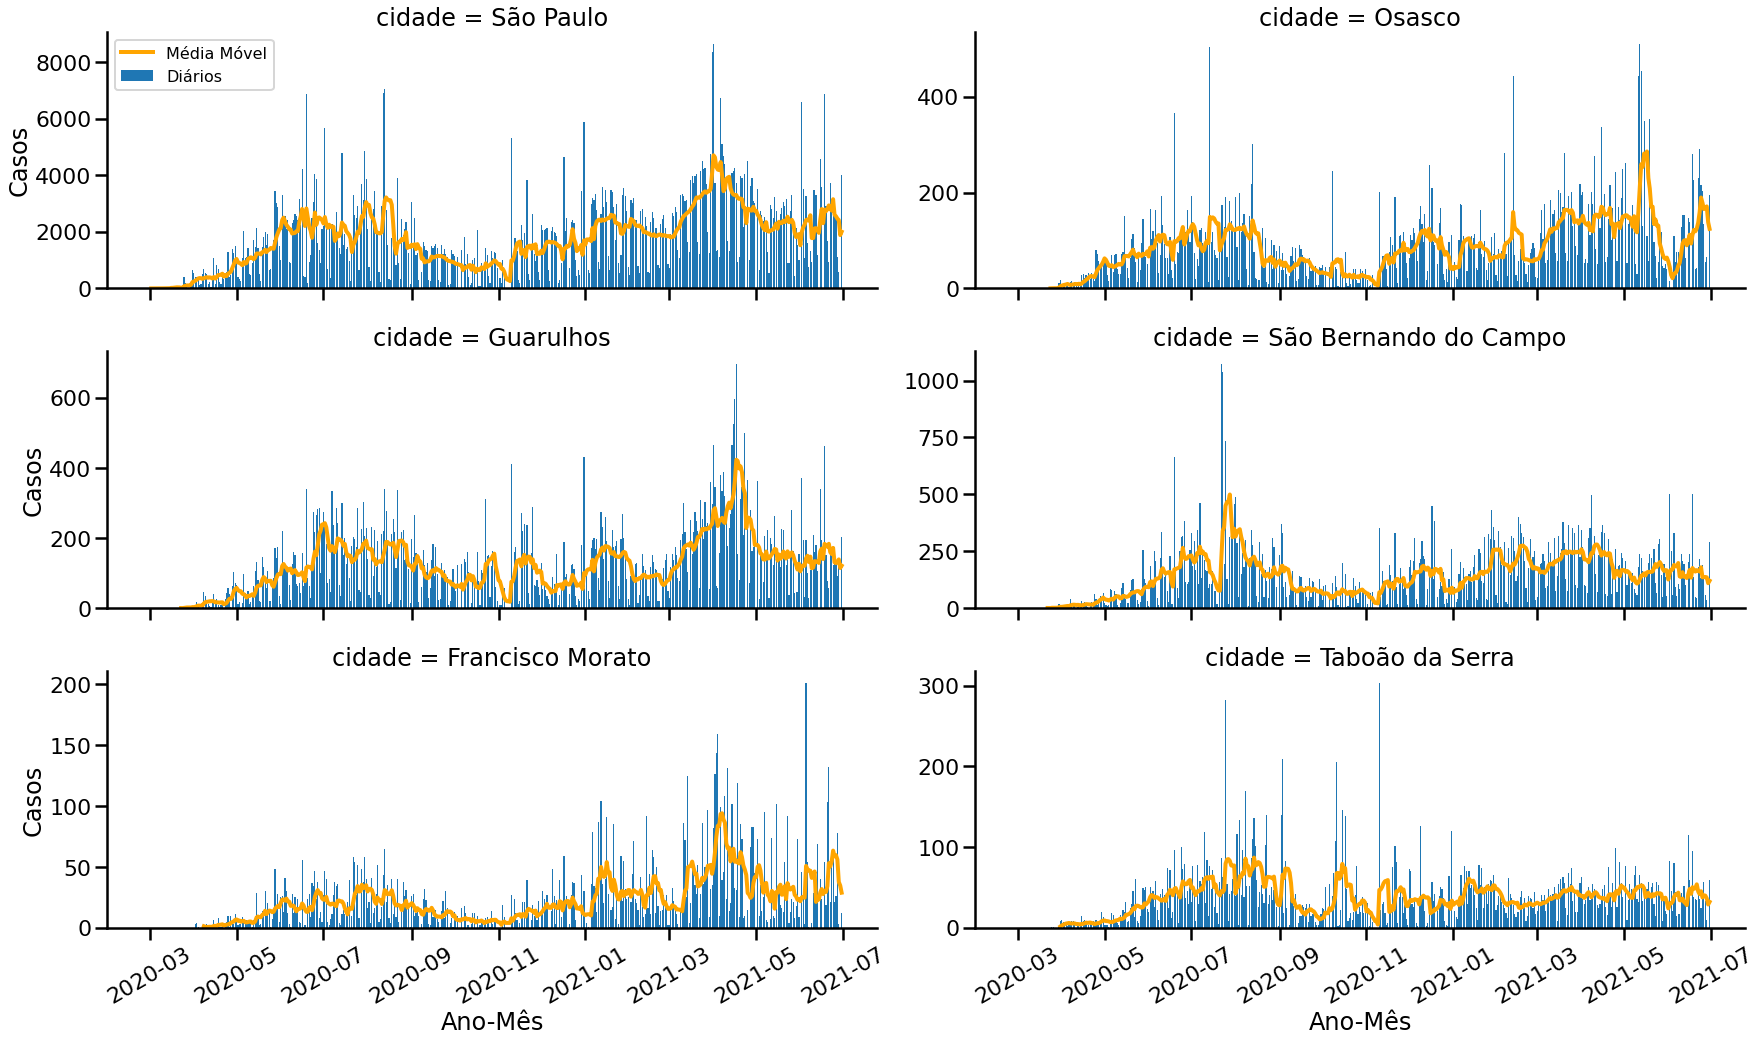

In [9]:
sns.set_context("poster")
g = sns.FacetGrid(data = df_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.5)
g.map_dataframe(plt.bar, x = "date", height = "new_confirmed", label = "Diários")
g.map_dataframe(sns.lineplot, x = "date", y = "ma_cases", linewidth = 4, label = "Média Móvel", color = "orange")
g.set_xticklabels(rotation = 30)
g.set_axis_labels("Ano-Mês", "Casos")
g.axes[0].legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
plt.show()

## Mortes

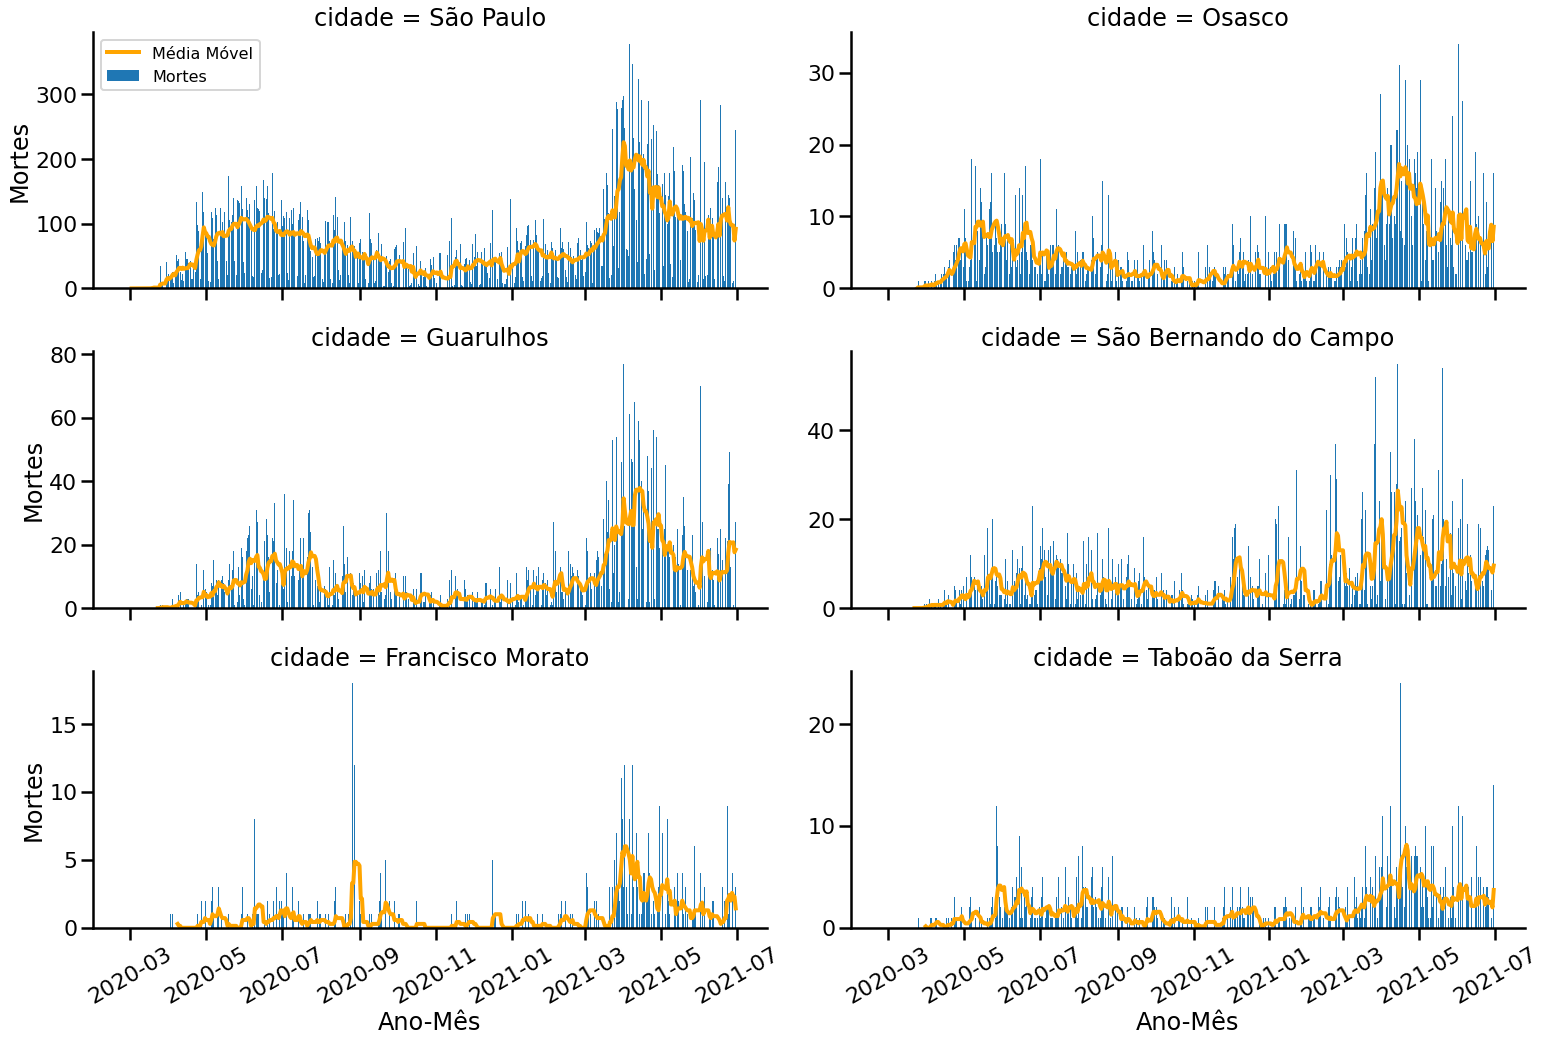

In [10]:
sns.set_context("poster")
g = sns.FacetGrid(data = df_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.2)
g.map_dataframe(plt.bar, x = "date", height = "new_deaths", label = "Mortes")
g.map_dataframe(sns.lineplot, x = "date", y = "ma_deaths", linewidth = 4, label = "Média Móvel", color = "orange")
g.set_axis_labels("Ano-Mês", "Mortes")
g.set_xticklabels(rotation = 30)
g.axes[0].legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
plt.show()

In [11]:
sns.set_context("talk")

## Analise de correlação

### Casos

In [12]:
sp_osa = smt.ccf(df_sp.loc[:,"new_confirmed"], df_osa.loc[:,"new_confirmed"], unbiased = False)
sp_osa_lag = range(0, len(df_osa))

sp_gru = smt.ccf(df_sp.loc[:,"new_confirmed"], df_gru.loc[:,"new_confirmed"], unbiased = False)
sp_gru_lag = range(0, len(df_gru))

sp_sbc = smt.ccf(df_sp.loc[:,"new_confirmed"], df_sbc.loc[:,"new_confirmed"], unbiased = False)
sp_sbc_lag = range(0, len(df_sbc))

sp_fm = smt.ccf(df_sp.loc[:,"new_confirmed"], df_fm.loc[:,"new_confirmed"], unbiased = False)
sp_fm_lag = range(0, len(df_fm))

sp_tab = smt.ccf(df_sp.loc[:,"new_confirmed"], df_tab.loc[:,"new_confirmed"], unbiased = False)
sp_tab_lag = range(0, len(df_tab))

In [13]:
corrs = [sp_osa, sp_gru, sp_sbc, sp_fm, sp_tab]
corr_lags = [sp_osa_lag, sp_gru_lag, sp_sbc_lag, sp_fm_lag, sp_tab_lag]
cidades = ["Osasco", "Guarulhos", "São Bernardo do Campo", "Francisco Morato", "Taboão da Serra"]

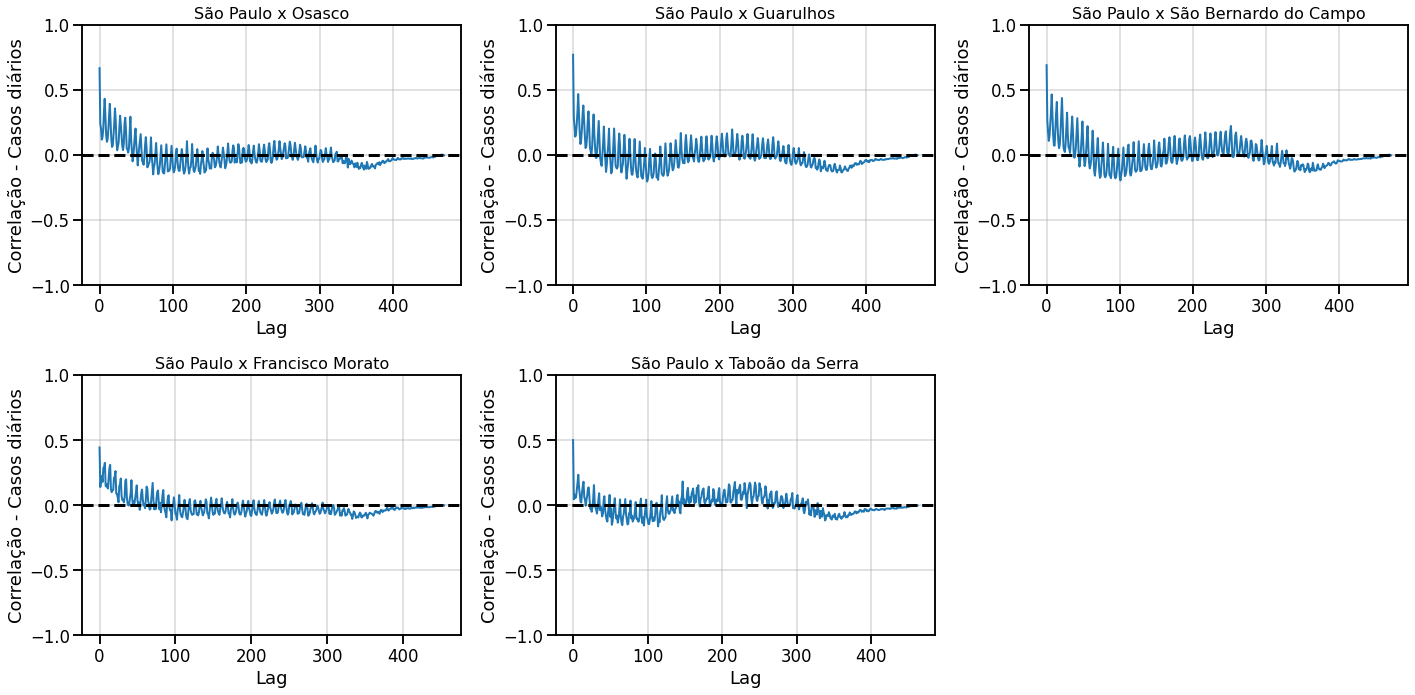

In [14]:
fig = plt.figure(figsize = (20, 10))

for k in range(1,6):
  fig.add_subplot(2, 3, k)
  plt.title("São Paulo x " + cidades[k -1], fontsize = 16)
  plt.plot(corr_lags[k - 1], corrs[k - 1], lw = 2)
  plt.ylim(-1,1)
  plt.xlabel("Lag")
  plt.ylabel("Correlação - Casos diários")
  plt.grid(alpha = .5)
  plt.axhline(y = 0, color = "black", lw = 3, ls = "--")
 
plt.tight_layout()
plt.show()

### Mortes

In [15]:
sp_osa = smt.ccf(df_sp.loc[:,"new_deaths"], df_osa.loc[:,"new_deaths"], unbiased = False)
sp_osa_lag = range(0, len(df_osa))

sp_gru = smt.ccf(df_sp.loc[:,"new_deaths"], df_gru.loc[:,"new_deaths"], unbiased = False)
sp_gru_lag = range(0, len(df_gru))

sp_sbc = smt.ccf(df_sp.loc[:,"new_deaths"], df_sbc.loc[:,"new_deaths"], unbiased = False)
sp_sbc_lag = range(0, len(df_sbc))

sp_fm = smt.ccf(df_sp.loc[:,"new_deaths"], df_fm.loc[:,"new_deaths"], unbiased = False)
sp_fm_lag = range(0, len(df_fm))

sp_tab = smt.ccf(df_sp.loc[:,"new_deaths"], df_tab.loc[:,"new_deaths"], unbiased = False)
sp_tab_lag = range(0, len(df_tab))

In [16]:
corrs = [sp_osa, sp_gru, sp_sbc, sp_fm, sp_tab]
corr_lags = [sp_osa_lag, sp_gru_lag, sp_sbc_lag, sp_fm_lag, sp_tab_lag]
cidades = ["Osasco", "Guarulhos", "São Bernardo do Campo", "Francisco Morato", "Taboão da Serra"]

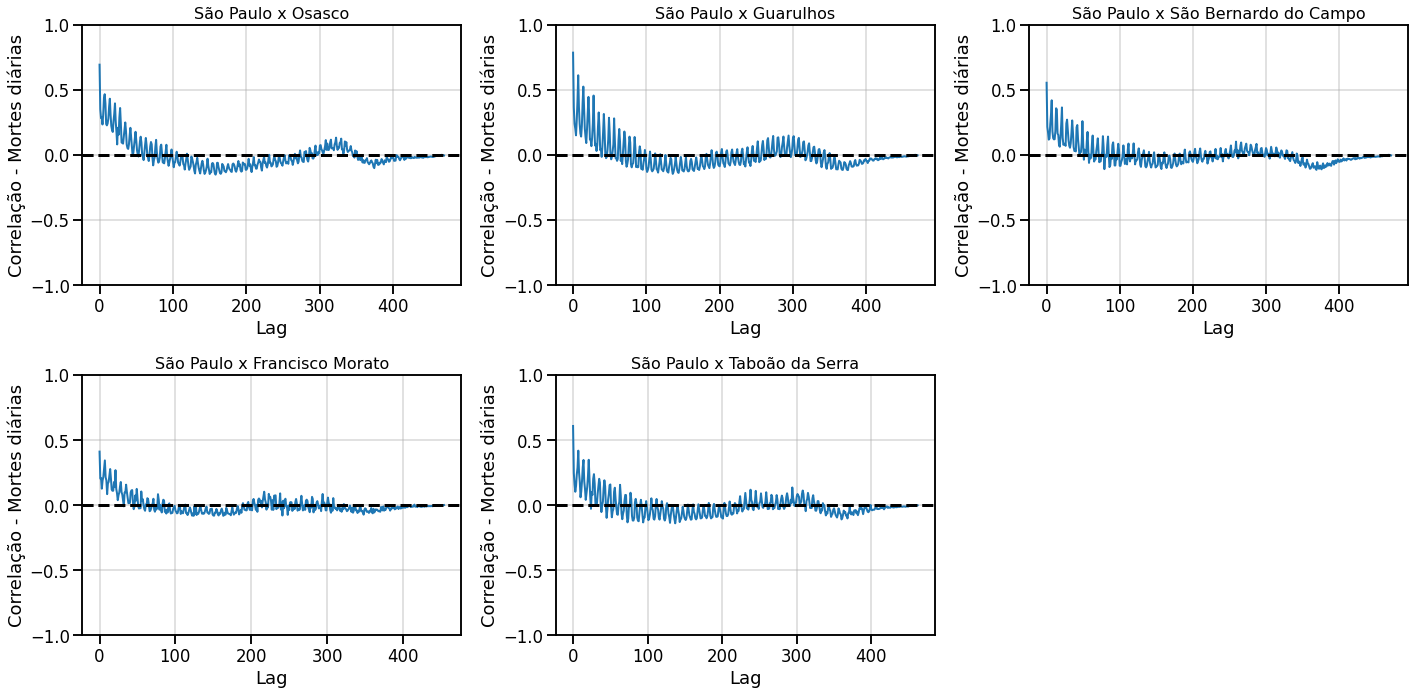

In [17]:
fig = plt.figure(figsize = (20, 10))

for k in range(1,6):
  fig.add_subplot(2, 3, k)
  plt.title("São Paulo x " + cidades[k -1], fontsize = 16)
  plt.plot(corr_lags[k - 1], corrs[k - 1], lw = 2)
  plt.ylim(-1,1)
  plt.xlabel("Lag")
  plt.ylabel("Correlação - Mortes diárias")
  plt.grid(alpha = .5)
  plt.axhline(y = 0, color = "black", lw = 3, ls = "--")

plt.tight_layout()
plt.show()

# Vacinação

# Estado

In [18]:
vac_estado.head()

,date,Dose,Contagem de Dose
0,2021-06-30,1° DOSE,227818
1,2021-06-29,1° DOSE,382714
2,2021-06-28,1° DOSE,288149
3,2021-06-27,1° DOSE,35104
4,2021-06-26,1° DOSE,301371


In [19]:
vac_estado_means = vac_estado.copy()
vac_estado_means.loc[(vac_estado_means["Dose"] == "1° DOSE"), "ma"] = vac_estado_means.loc[vac_estado_means.Dose.shift() == "1° DOSE", "Contagem de Dose"].rolling(window = 7, center = False).mean()
vac_estado_means.loc[(vac_estado_means["Dose"] == "2° DOSE"), "ma"] = vac_estado_means.loc[vac_estado_means.Dose.shift() == "2° DOSE", "Contagem de Dose"].rolling(window = 7, center = False).mean()

In [20]:
vac_estado_means = vac_estado_means[:-4]

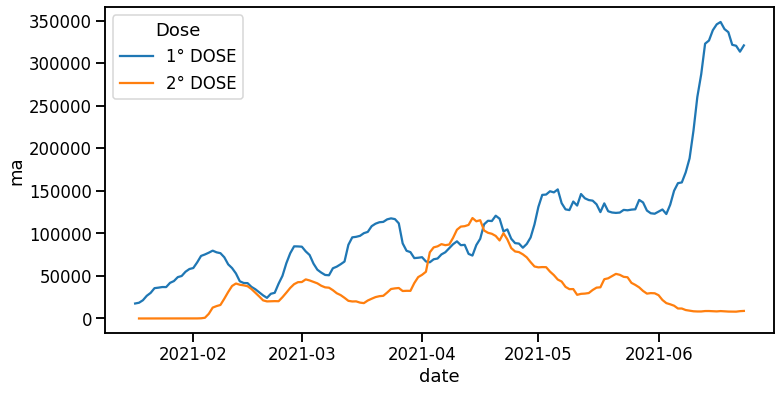

In [21]:
plt.figure(figsize=(12,6))

sns.lineplot(data = vac_estado_means, x = "date", y = "ma", hue = "Dose")

In [22]:
duas_doses = vac_estado.groupby("date").sum().reset_index()
duas_doses_means = duas_doses.copy()
duas_doses_means.loc[:,"ma"] = duas_doses_means.loc[:,"Contagem de Dose"].rolling(window = 7, center = False).mean()

In [23]:
duas_doses.loc[:,"cumulativo"] = duas_doses.loc[:,"Contagem de Dose"].cumsum()

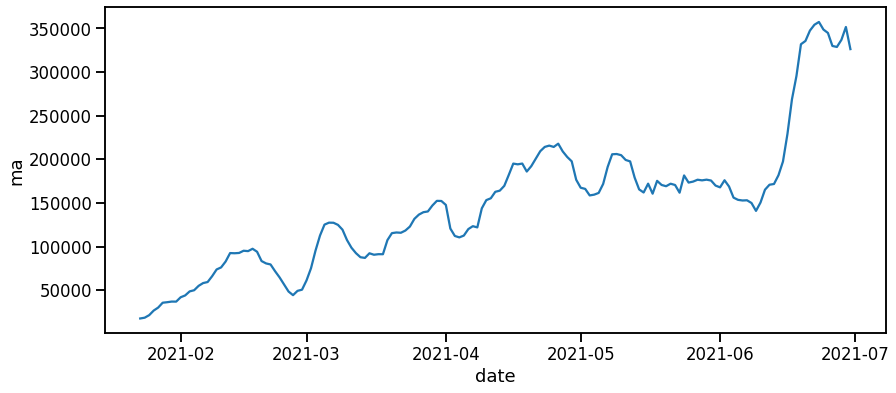

In [24]:
plt.figure(figsize = (14,6))
sns.lineplot(data = duas_doses_means, x = "date", y = "ma")

# Cidades

In [25]:
vac_sp.loc[:,"ma"] = vac_sp.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_sp.loc[:,"cumulativo"] = vac_sp.loc[:,"Doses Aplicadas"].cumsum()

vac_osa.loc[:,"ma"] = vac_osa.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_osa.loc[:,"cumulativo"] = vac_osa.loc[:,"Doses Aplicadas"].cumsum()

vac_gru.loc[:,"ma"] = vac_gru.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_gru.loc[:,"cumulativo"] = vac_gru.loc[:,"Doses Aplicadas"].cumsum()

vac_sbc.loc[:,"ma"] = vac_sbc.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_sbc.loc[:,"cumulativo"] = vac_sbc.loc[:,"Doses Aplicadas"].cumsum()

vac_fm.loc[:,"ma"] = vac_fm.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_fm.loc[:,"cumulativo"] = vac_fm.loc[:,"Doses Aplicadas"].cumsum()

vac_tab.loc[:,"ma"] = vac_tab.loc[:,"Doses Aplicadas"].rolling(window = 7, center = False).mean()
vac_tab.loc[:,"cumulativo"] = vac_tab.loc[:,"Doses Aplicadas"].cumsum()

In [26]:
vac_cities = pd.concat([vac_sp, vac_osa, vac_gru, vac_sbc, vac_fm, vac_tab],
                       axis = 0, join = "inner", keys = ["São Paulo","Osasco","Guarulhos",
                                                    "São Bernando do Campo", "Francisco Morato",
                                                    "Taboão da Serra"]).reset_index()

vac_cities.drop("level_1", axis = 1, inplace = True)
vac_cities.rename(columns = {"level_0": "cidade"}, inplace = True)
vac_cities

,cidade,Data,Doses Aplicadas,ma,cumulativo
0,São Paulo,2021-01-17,162,NaN,162
1,São Paulo,2021-01-18,1040,NaN,1202
2,São Paulo,2021-01-19,7943,NaN,9145
3,São Paulo,2021-01-20,12974,NaN,22119
4,São Paulo,2021-01-21,27627,NaN,49746
...,...,...,...,...,...
951,Taboão da Serra,2021-06-25,4616,2570.857143,122573
952,Taboão da Serra,2021-06-26,3,2059.285714,122576
953,Taboão da Serra,2021-06-28,2822,2461.714286,125398
954,Taboão da Serra,2021-06-29,2189,2475.428571,127587


## Taxas diárias

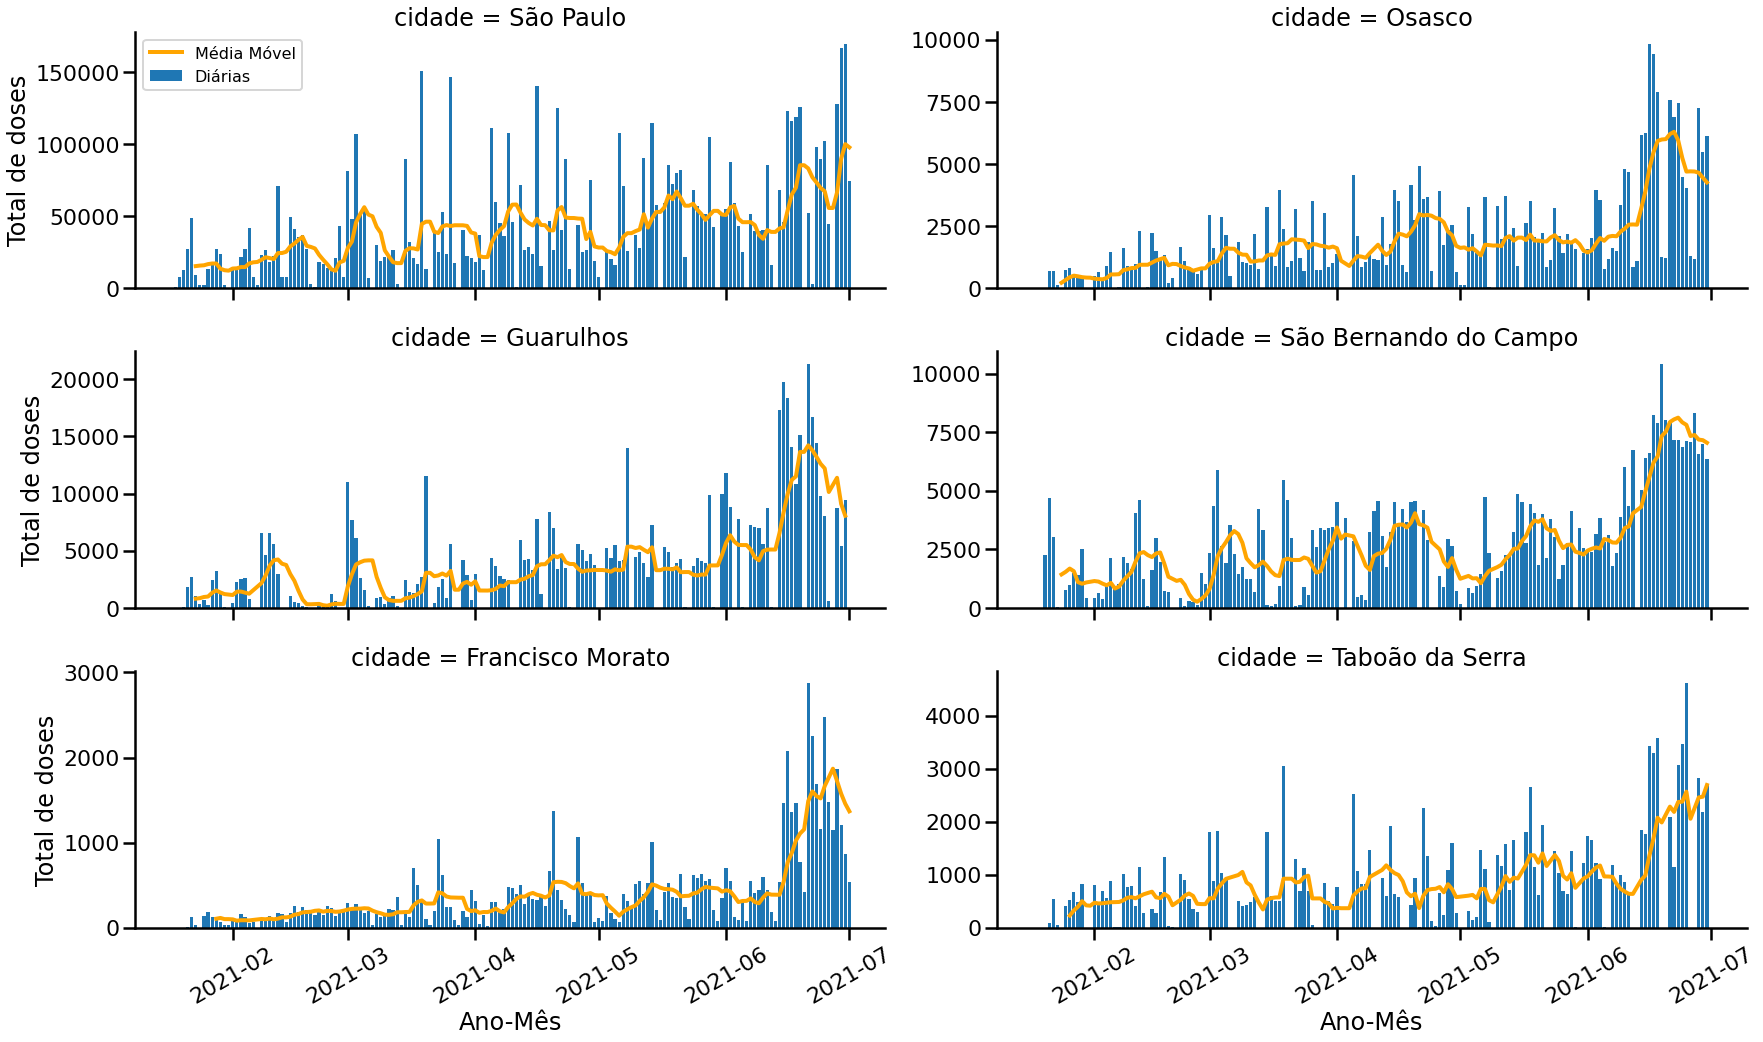

In [27]:
sns.set_context("poster")
g = sns.FacetGrid(data = vac_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.5)
g.map_dataframe(plt.bar, x = "Data", height = "Doses Aplicadas", label = "Diárias")
g.map_dataframe(sns.lineplot, x = "Data", y = "ma", linewidth = 4, color = "orange", label = "Média Móvel")
g.set_xticklabels(rotation = 30)
g.set_axis_labels("Ano-Mês", "Total de doses")
g.axes[0].legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
plt.show()

### Correlação

In [28]:
sp_osa = smt.ccf(vac_sp.loc[:,"Doses Aplicadas"], vac_osa.loc[:,"Doses Aplicadas"], unbiased = False)
sp_osa_lag = range(0, len(vac_osa))

sp_gru = smt.ccf(vac_sp.loc[:,"Doses Aplicadas"], vac_gru.loc[:,"Doses Aplicadas"], unbiased = False)
sp_gru_lag = range(0, len(vac_gru))

sp_sbc = smt.ccf(vac_sp.loc[:,"Doses Aplicadas"], vac_sbc.loc[:,"Doses Aplicadas"], unbiased = False)
sp_sbc_lag = range(0, len(vac_sbc))

sp_fm = smt.ccf(vac_sp.loc[:,"Doses Aplicadas"], vac_fm.loc[:,"Doses Aplicadas"], unbiased = False)
sp_fm_lag = range(0, len(vac_fm))

sp_tab = smt.ccf(vac_sp.loc[:,"Doses Aplicadas"], vac_tab.loc[:,"Doses Aplicadas"], unbiased = False)
sp_tab_lag = range(0, len(vac_tab))

In [29]:
corrs = [sp_osa, sp_gru, sp_sbc, sp_fm, sp_tab]
corr_lags = [sp_osa_lag, sp_gru_lag, sp_sbc_lag, sp_fm_lag, sp_tab_lag]
cidades = ["Osasco", "Guarulhos", "São Bernardo do Campo", "Francisco Morato", "Taboão da Serra"]

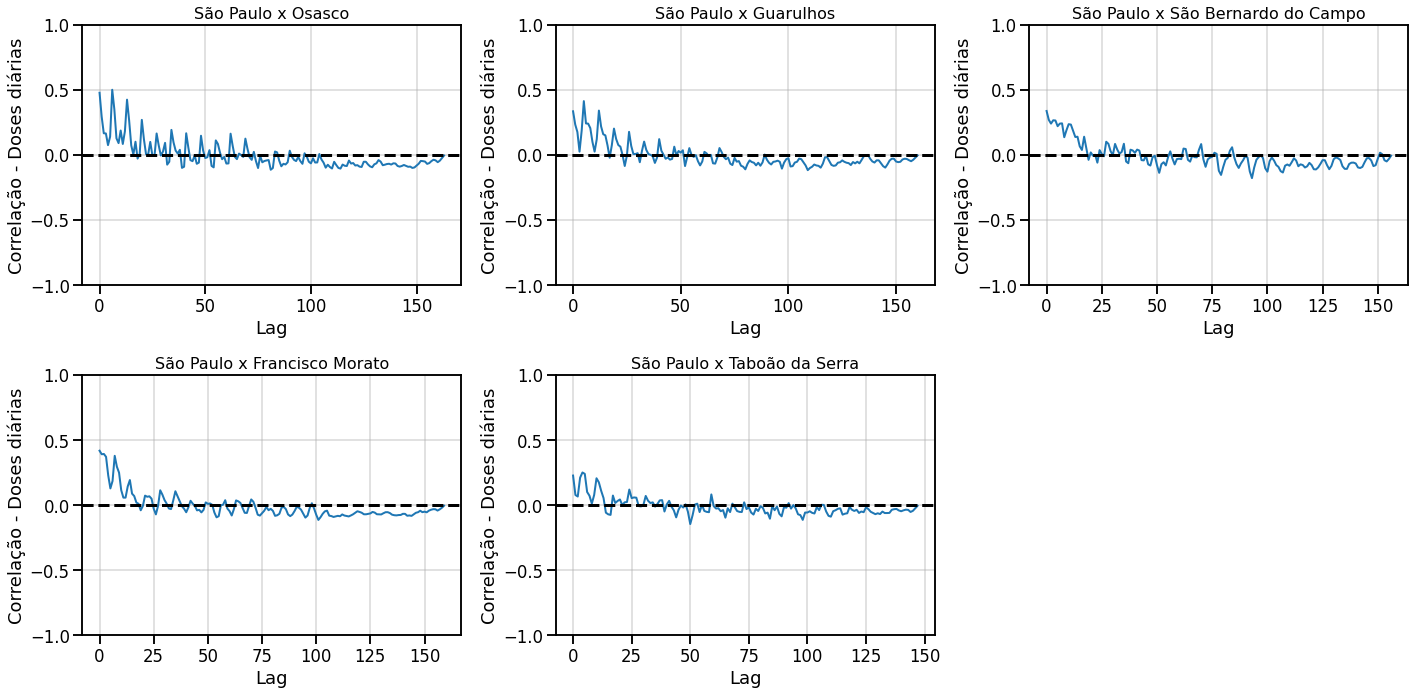

In [30]:
sns.set_context("talk")

fig = plt.figure(figsize = (20, 10))

for k in range(1,6):
  fig.add_subplot(2, 3, k)
  plt.title("São Paulo x " + cidades[k -1], fontsize = 16)
  plt.plot(corr_lags[k - 1], corrs[k - 1], lw = 2)
  plt.ylim(-1,1)
  plt.xlabel("Lag")
  plt.ylabel("Correlação - Doses diárias")
  plt.grid(alpha = .5)
  plt.axhline(y = 0, color = "black", lw = 3, ls = "--")
 
plt.tight_layout()
plt.show()

In [56]:
sns.reset_defaults()

## Cumulativo

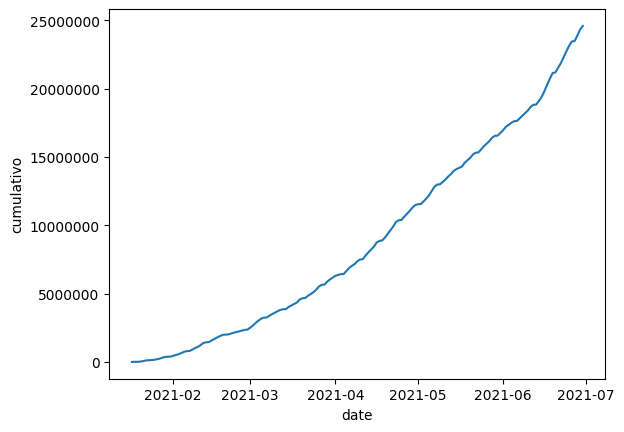

In [57]:
sns.lineplot(data = duas_doses, x = "date", y = "cumulativo")
plt.ticklabel_format(style='plain', axis='y')

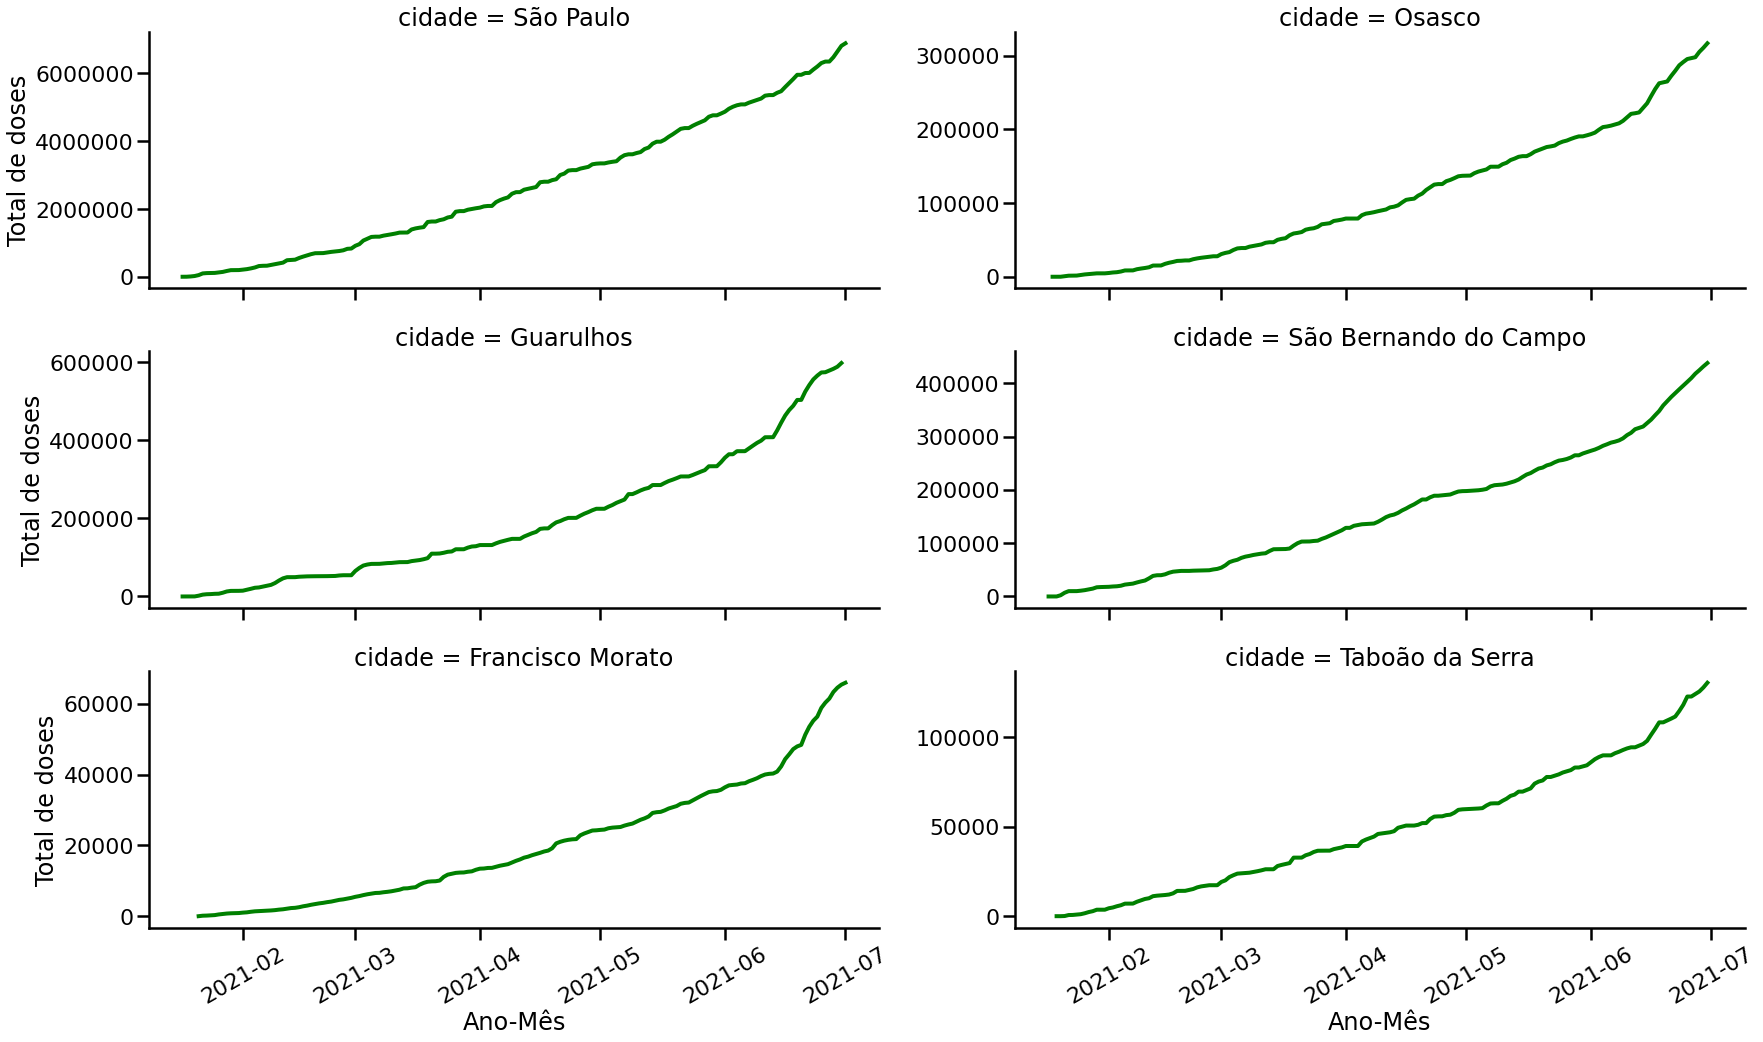

In [73]:
sns.set_context("poster")
g = sns.FacetGrid(data = vac_cities, col = "cidade", col_wrap = 2, sharey = False, height = 5, aspect = 2.5)
g.map_dataframe(sns.lineplot, x = "Data", y = "cumulativo", linewidth = 4, color = "green")
g.set_xticklabels(rotation = 30)
g.set_axis_labels("Ano-Mês", "Total de doses")
g.axes.flat[0].ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

# Previsões

In [190]:
def run_model(df, 
              periods,
              changepoints = None,
              n_changepoints = 25, 
              changepoint_prior_scale = 0.05, 
              changepoint_range = 0.8,
              holidays = None,
              growth = "linear",
              cap = None):
  
  mx = Prophet(changepoints = changepoints, 
               n_changepoints = n_changepoints,
               changepoint_prior_scale = changepoint_prior_scale,
               changepoint_range = changepoint_range,
               holidays = holidays,
               growth = growth) # chama o objeto de modelo

  mx.fit(df) # associa o modelo ao dataframe de treino

  if growth == "logistic" :
    df_prev = mx.make_future_dataframe(periods = periods)
    df_prev.loc[:,"cap"] = cap.repeat(len(df_prev)) # cria o dataframe de previsão que vai ser gerado mas não utilizado fora
    prev = mx.predict(df_prev) # faz a previsao baseada no modelo ajustado e no dataframe de previsao

  else : 
    df_prev = mx.make_future_dataframe(periods = periods) # cria o dataframe de previsão que vai ser gerado mas não utilizado fora
    prev = mx.predict(df_prev) # faz a previsao baseada no modelo ajustado e no dataframe de previsao

  return mx, prev # retorna o modelo como elemento [0], e a previsao como elemento [1]

### Para a função rodar na forma mais básica, precisamos apenas passar o dataframe de treino, já formatado como o prophet
### usa, e o periods que vamos estimar os dados.

### Como há uma série de parâmetros da função Prophet, você pode adicioná-los na definição da função.
### Para a aula, vamos brincar com os parâmetros de changepoints, os quais eu deixei com o default da função.

## Taxas diarias

In [306]:
# sem teste
dsy_estado = pd.DataFrame()

dsy_estado.loc[:,"ds"] = duas_doses.loc[:,"date"]
dsy_estado.loc[:,"y"] = duas_doses.loc[:,"Contagem de Dose"]

dsy_estado_teste = pd.DataFrame()

dsy_estado_teste.loc[:,"ds"] = duas_doses.loc[:,"date"]
dsy_estado_teste.loc[:,"y"] = duas_doses.loc[:,"Contagem de Dose"]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


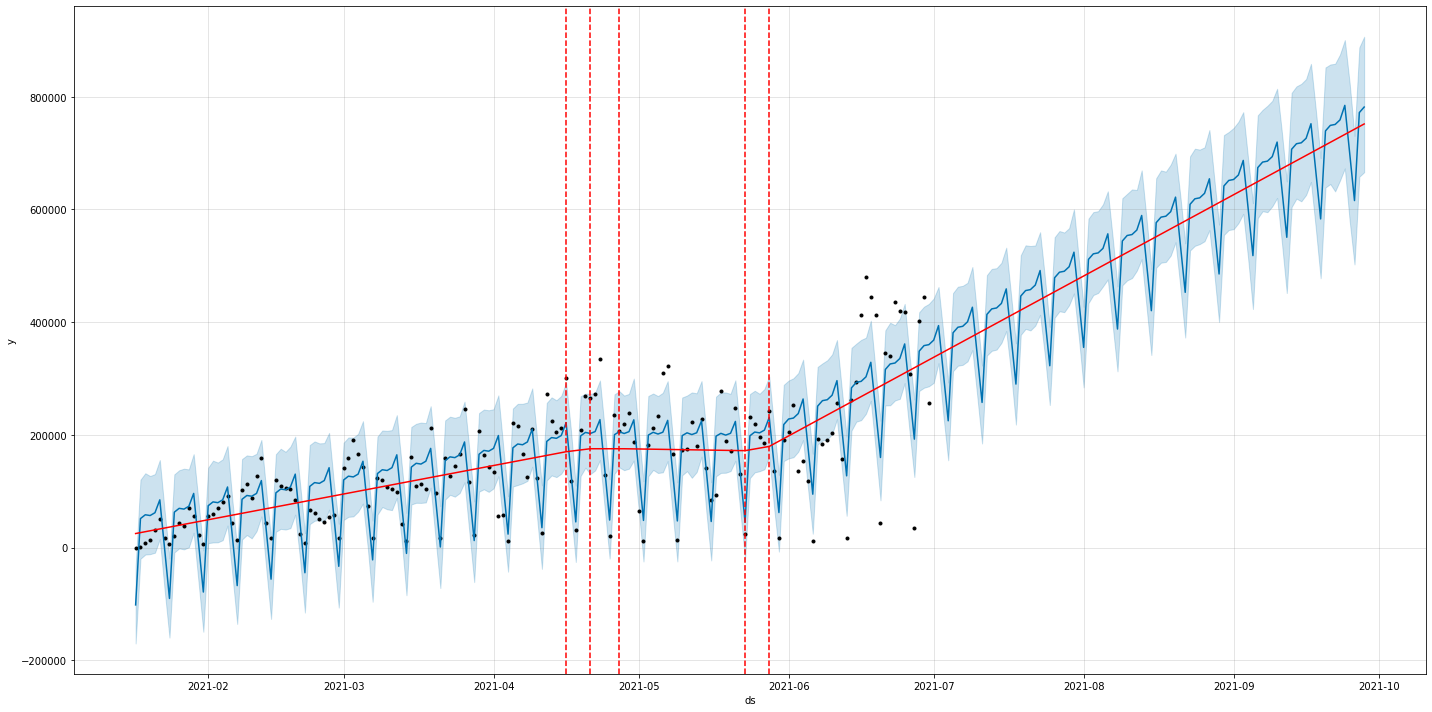

In [337]:
# teste do ajuste inicial
m1 = run_model(df = dsy_estado, periods = 90, changepoint_prior_scale = 0.3)

fig = m1[0].plot(m1[1], figsize = (20,10));
# plt.plot(df_estado_teste.loc[:,"ds"], df_estado_teste.loc[:,"y"],"r.")
plt.ticklabel_format(style='plain', axis='y')
add_changepoints_to_plot(fig.gca(), m1[0], m1[1])
plt.show()

Definido um modelo que identifica a meta de 600000~800000 diários, vamos ver o efeito da data:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


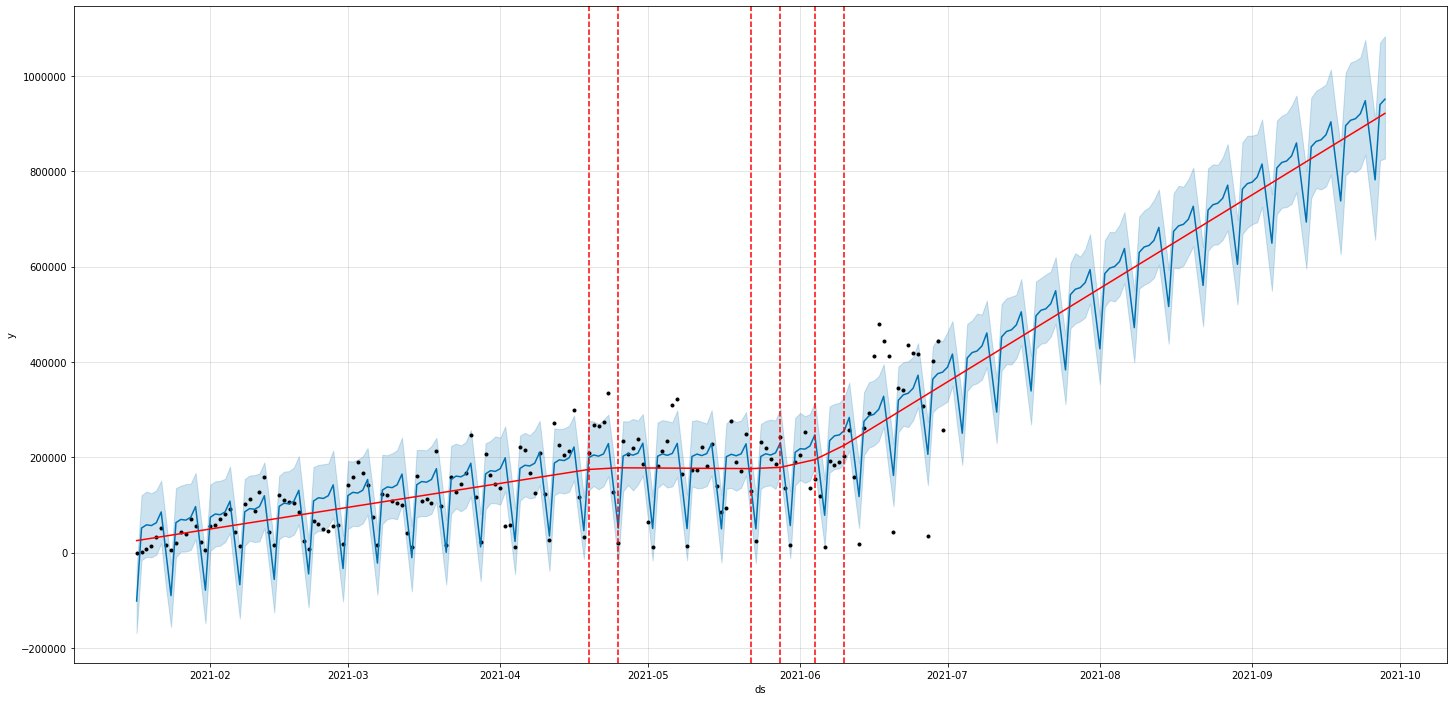

In [332]:
m2 = run_model(df = dsy_estado, periods = 90, changepoint_prior_scale = 0.3,
               changepoint_range = 1)

fig = m2[0].plot(m2[1], figsize = (20,10));
# plt.plot(df_estado_teste.loc[:,"ds"], df_estado_teste.loc[:,"y"],"r.")
plt.ticklabel_format(style='plain', axis='y')
add_changepoints_to_plot(fig.gca(), m2[0], m2[1])
plt.show()

In [311]:
df_cv = cross_validation(m2[0], initial = "80 days", period = "7 days", horizon = "7 days")

INFO:fbprophet:Making 12 forecasts with cutoffs between 2021-04-07 00:00:00 and 2021-06-23 00:00:00


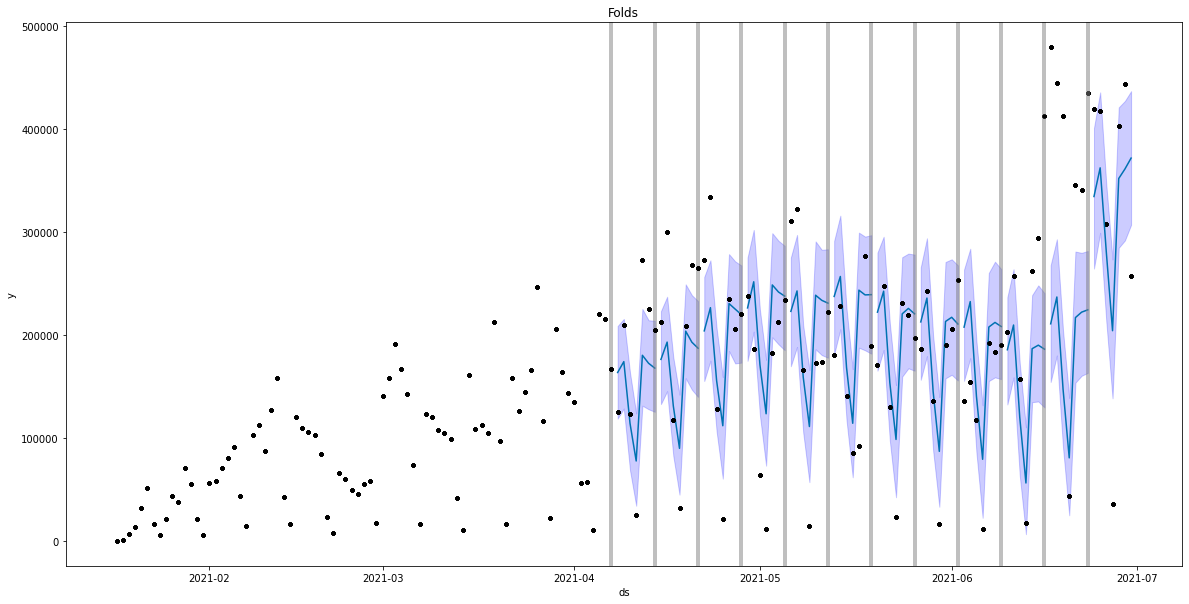

In [314]:
sns.reset_orig()
lista_cutoff = df_cv['cutoff'].unique()

plt.figure(figsize = (20,10))
for cutoff in lista_cutoff:

    df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
    ax = plt.plot(m2[0].history['ds'].values, m2[0].history['y'], 'k.')

    plt.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2', label='previsão')

    plt.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                    df_cv_cut['yhat_upper'], color='blue',
                    alpha=0.2, label='intervalo de confiança')
    
    plt.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5, label='cutoff')
    
plt.title(f'Folds')
plt.ylabel('y')
plt.xlabel('ds')
fig.tight_layout()
plt.show()

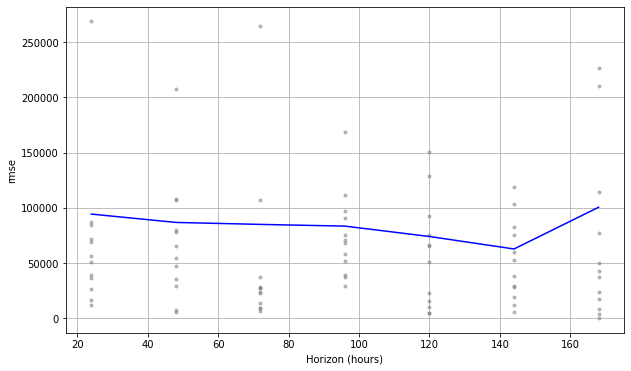

In [315]:
plot_cross_validation_metric(df_cv, metric = "rmse");

In [318]:
vac_sp.columns

Index(['Data', 'Doses Aplicadas', 'ma', 'cumulativo'], dtype='object')

In [333]:
dsy_sp = pd.DataFrame()
dsy_sp.loc[:,"ds"] = vac_sp.loc[:,"Data"]
dsy_sp.loc[:,"y"] = vac_sp.loc[:,"Doses Aplicadas"]

dsy_osa = pd.DataFrame()
dsy_osa.loc[:,"ds"] = vac_osa.loc[:,"Data"]
dsy_osa.loc[:,"y"] = vac_osa.loc[:,"Doses Aplicadas"]

dsy_gru = pd.DataFrame()
dsy_gru.loc[:,"ds"] = vac_gru.loc[:,"Data"]
dsy_gru.loc[:,"y"] = vac_gru.loc[:,"Doses Aplicadas"]

dsy_sbc = pd.DataFrame()
dsy_sbc.loc[:,"ds"] = vac_sbc.loc[:,"Data"]
dsy_sbc.loc[:,"y"] = vac_sbc.loc[:,"Doses Aplicadas"]

dsy_fm = pd.DataFrame()
dsy_fm.loc[:,"ds"] = vac_fm.loc[:,"Data"]
dsy_fm.loc[:,"y"] = vac_fm.loc[:,"Doses Aplicadas"]

dsy_tab = pd.DataFrame()
dsy_tab.loc[:,"ds"] = vac_tab.loc[:,"Data"]
dsy_tab.loc[:,"y"] = vac_tab.loc[:,"Doses Aplicadas"]


In [369]:
m1_sp = run_model(df = dsy_sp, periods = 90, changepoint_prior_scale = 2, changepoint_range = 1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [370]:
m1_osa = run_model(df = dsy_osa, periods = 90, changepoint_prior_scale = 0.3, changepoint_range = 1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [371]:
m1_gru = run_model(df = dsy_gru, periods = 90, changepoint_prior_scale = 0.3, changepoint_range = 1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [372]:
m1_sbc = run_model(df = dsy_sbc, periods = 90, changepoint_prior_scale = 0.3, changepoint_range = 1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [373]:
m1_fm = run_model(df = dsy_fm, periods = 90, changepoint_prior_scale = 0.3, changepoint_range = 1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [374]:
m1_tab = run_model(df = dsy_tab, periods = 90, changepoint_prior_scale = 0.3, changepoint_range = 1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [375]:
m1_tot = [m1_sp, m1_osa, m1_gru, m1_sbc, m1_fm, m1_tab]
cidades_modelos = ["São Paulo"] + cidades
cidades_modelos

['São Paulo',
 'Osasco',
 'Guarulhos',
 'São Bernardo do Campo',
 'Francisco Morato',
 'Taboão da Serra']

<Figure size 1440x720 with 0 Axes>

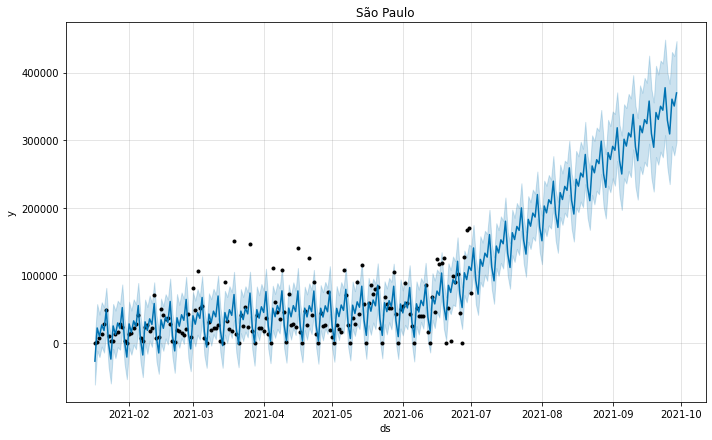

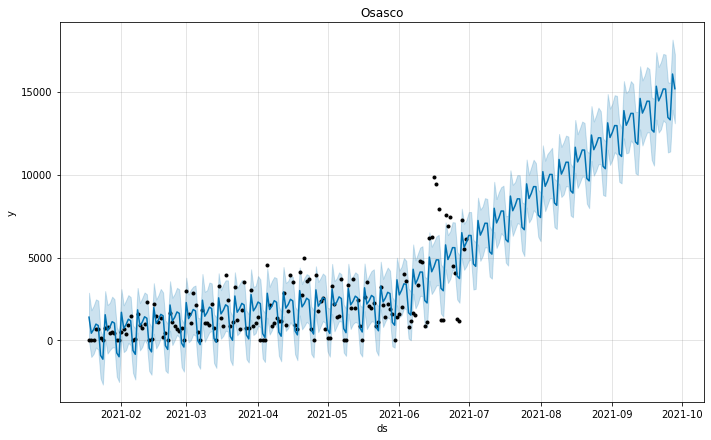

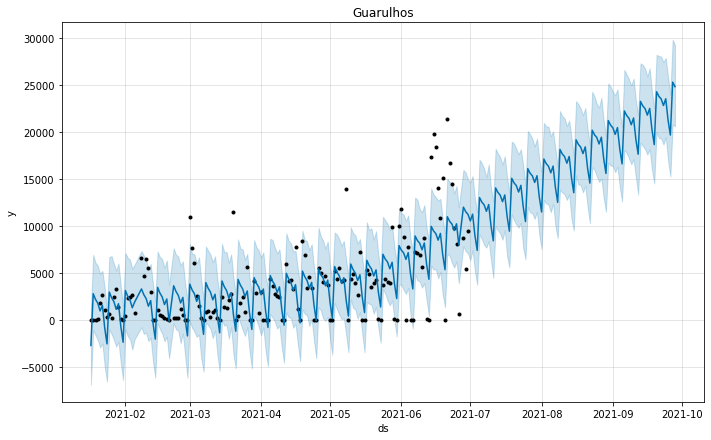

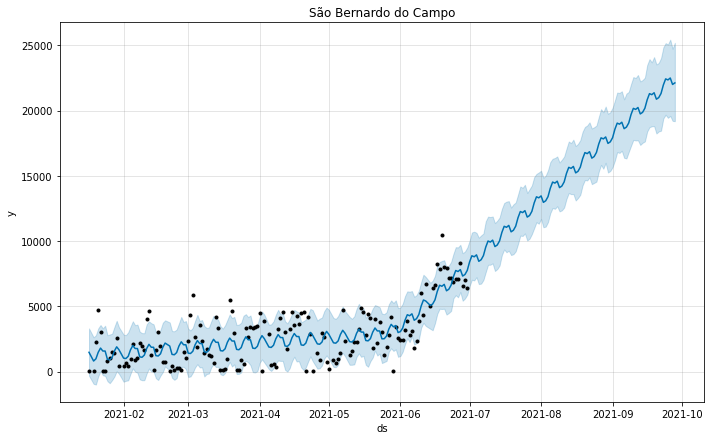

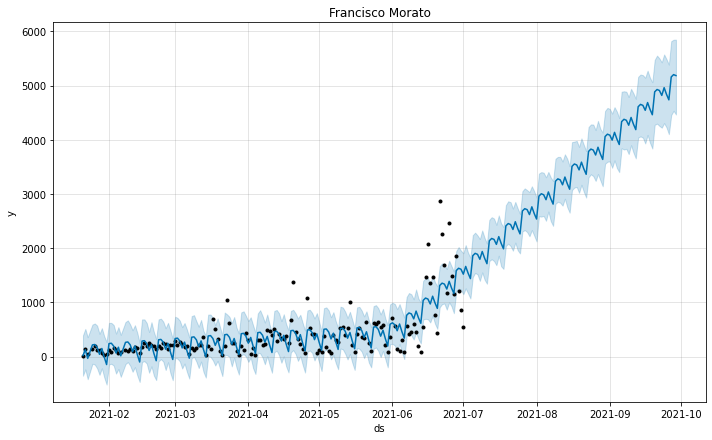

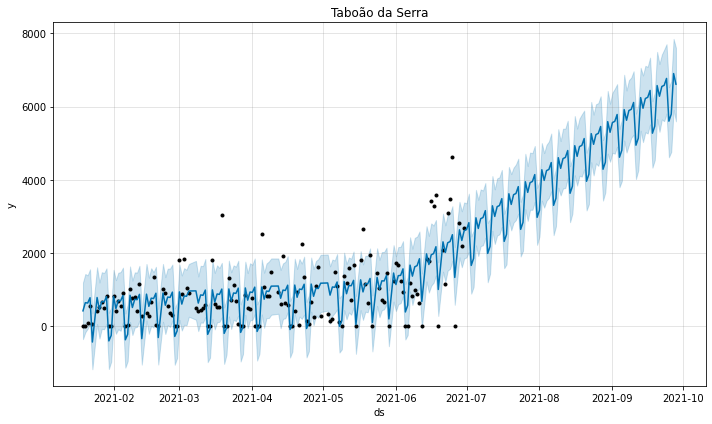

In [376]:
fig = plt.figure(figsize = (20,10))

for k in range(0,6):
  m1_tot[k][0].plot(m1_tot[k][1]);
  plt.title(cidades_modelos[k])
  plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## Cumulativo

In [377]:
pop_sp = casos_full.query("city == 'São Paulo'").loc[:,"estimated_population"].unique()
pop_osa = casos_full.query("city == 'Osasco'").loc[:,"estimated_population"].unique()
pop_gru = casos_full.query("city == 'Guarulhos'").loc[:,"estimated_population"].unique()
pop_sbc = casos_full.query("city == 'São Bernardo do Campo'").loc[:,"estimated_population"].unique()
pop_fm = casos_full.query("city == 'Francisco Morato'").loc[:,"estimated_population"].unique()
pop_tab = casos_full.query("city == 'Taboão da Serra'").loc[:,"estimated_population"].unique()

In [200]:
# sem teste
dsy_estado = pd.DataFrame()



,ds,y,cap
0,2021-01-17,100,46289333.0
1,2021-01-18,979,46289333.0
2,2021-01-19,8430,46289333.0
3,2021-01-20,22623,46289333.0
4,2021-01-21,54732,46289333.0
...,...,...,...
160,2021-06-26,23447232,46289333.0
161,2021-06-27,23482906,46289333.0
162,2021-06-28,23885669,46289333.0
163,2021-06-29,24329695,46289333.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


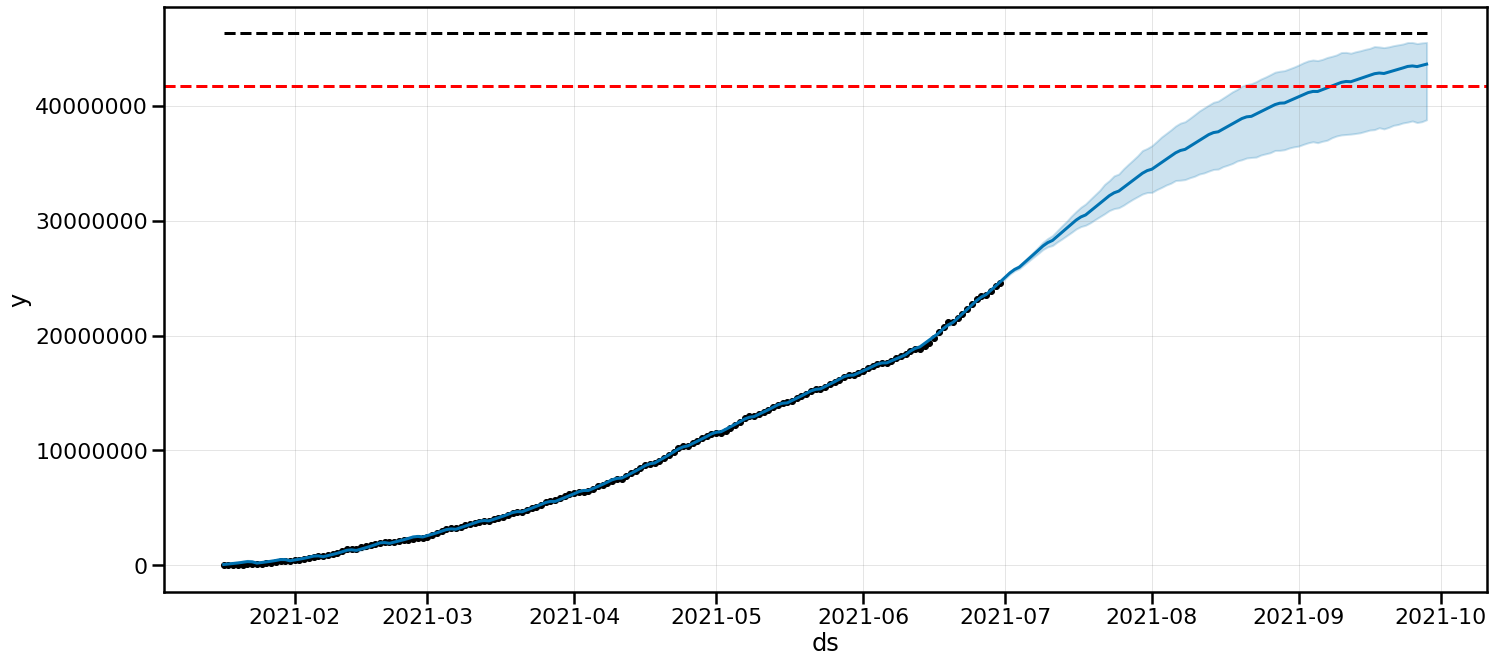

In [208]:
m3 = run_model(df = dsy_estado, periods = 90, changepoint_prior_scale = 0.2,
               changepoint_range = 1, growth = "logistic", cap = pop_sp)

fig = m3[0].plot(m3[1], figsize = (20,10));
# plt.plot(df_estado_teste.loc[:,"ds"], df_estado_teste.loc[:,"y"],"r.")
plt.ticklabel_format(style='plain', axis='y')
plt.axhline(y = pop_sp*0.9, color = "red", lw = 3, ls = "--")

plt.show()

<Figure size 1440x720 with 0 Axes>

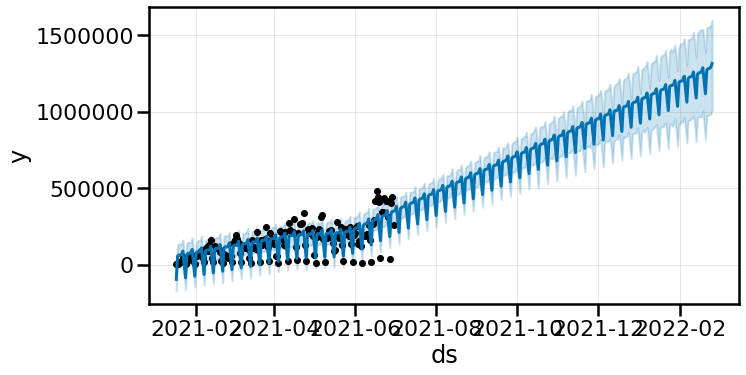

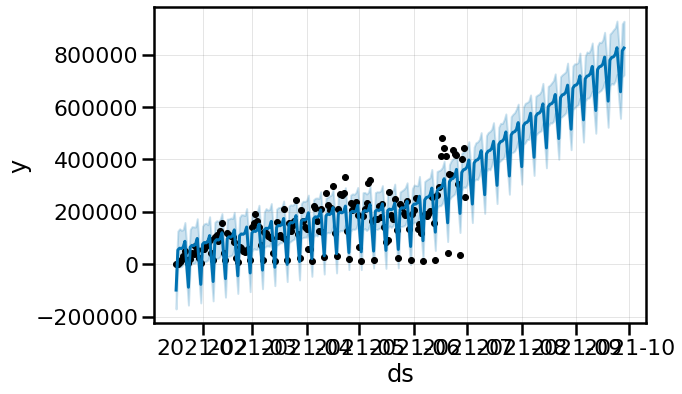

1